# IE 7300 Project Group 5 - Client Subscription Classification

UCI Bank Marketing Dataset - https://archive.ics.uci.edu/dataset/222/bank+marketing

## Data Loading

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc
from scipy.optimize import minimize, Bounds

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
# Reading original data
bank_df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [3]:
# Converting duration column from seconds to minutes
bank_df['duration'] = round(bank_df['duration'] / 60, 1)

# Drop day_of_week and european rate columns
bank_df.drop(['day_of_week', 'euribor3m'], axis = 1, inplace = True)

In [4]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,4.4,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,2.5,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,3.8,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,2.5,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,5.1,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no


In [5]:
bank_df.shape

(41188, 19)

## Exploratory Data Analysis

In [6]:
# Checking for null values
bank_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
nr.employed       0
y                 0
dtype: int64

In [7]:
# Number of unknown values in each column
bank_df[bank_df == 'unknown'].count()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
nr.employed          0
y                    0
dtype: int64

**We can see that there are no null values in the dataset, however there are unknown values in job (330), marital (80), education (1731), default (8597), housing (990), loan (990) columns as seen above.**

In [8]:
# Checking column data types
bank_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
duration          float64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
nr.employed       float64
y                  object
dtype: object

**We have a mix of numerical features like age, call duration, number of campaigns, consumer confidence index, etc. and categorical features like job type, marital status, education level, housing loan, and more.**

**Note that our target column 'y' describes whether term deposit offered by the bank was subscribed to or not and it is categorical in nature.**

In [9]:
# Descriptive statistics for bank dataframe
bank_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,4.305006,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,5167.035911
std,10.42125,4.321572,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,4963.600000
25%,32.00000,1.700000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,5099.100000
50%,38.00000,3.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,5191.000000
75%,47.00000,5.300000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,5228.100000
max,98.00000,82.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5228.100000


<AxesSubplot:xlabel='y', ylabel='count'>

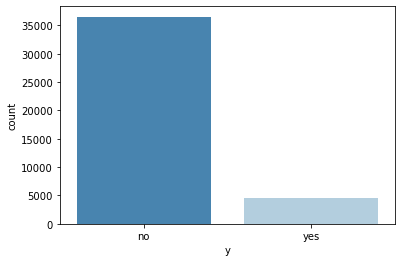

In [10]:
# Count of target variable - term deposit subscribes: 'yes' or 'no'
sns.countplot(x = 'y', data = bank_df, palette = 'Blues_r')

In [13]:
bank_df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

**From this chart, we can see there is a major imbalance in the target column. To handle this imbalance, SMOTE technique will be used to balance the data by generating synthentic samples for minority class ('yes'). The model performance with vs. without SMOTE will be used to see how this technique can impact the final results.**

### Univariate Analysis

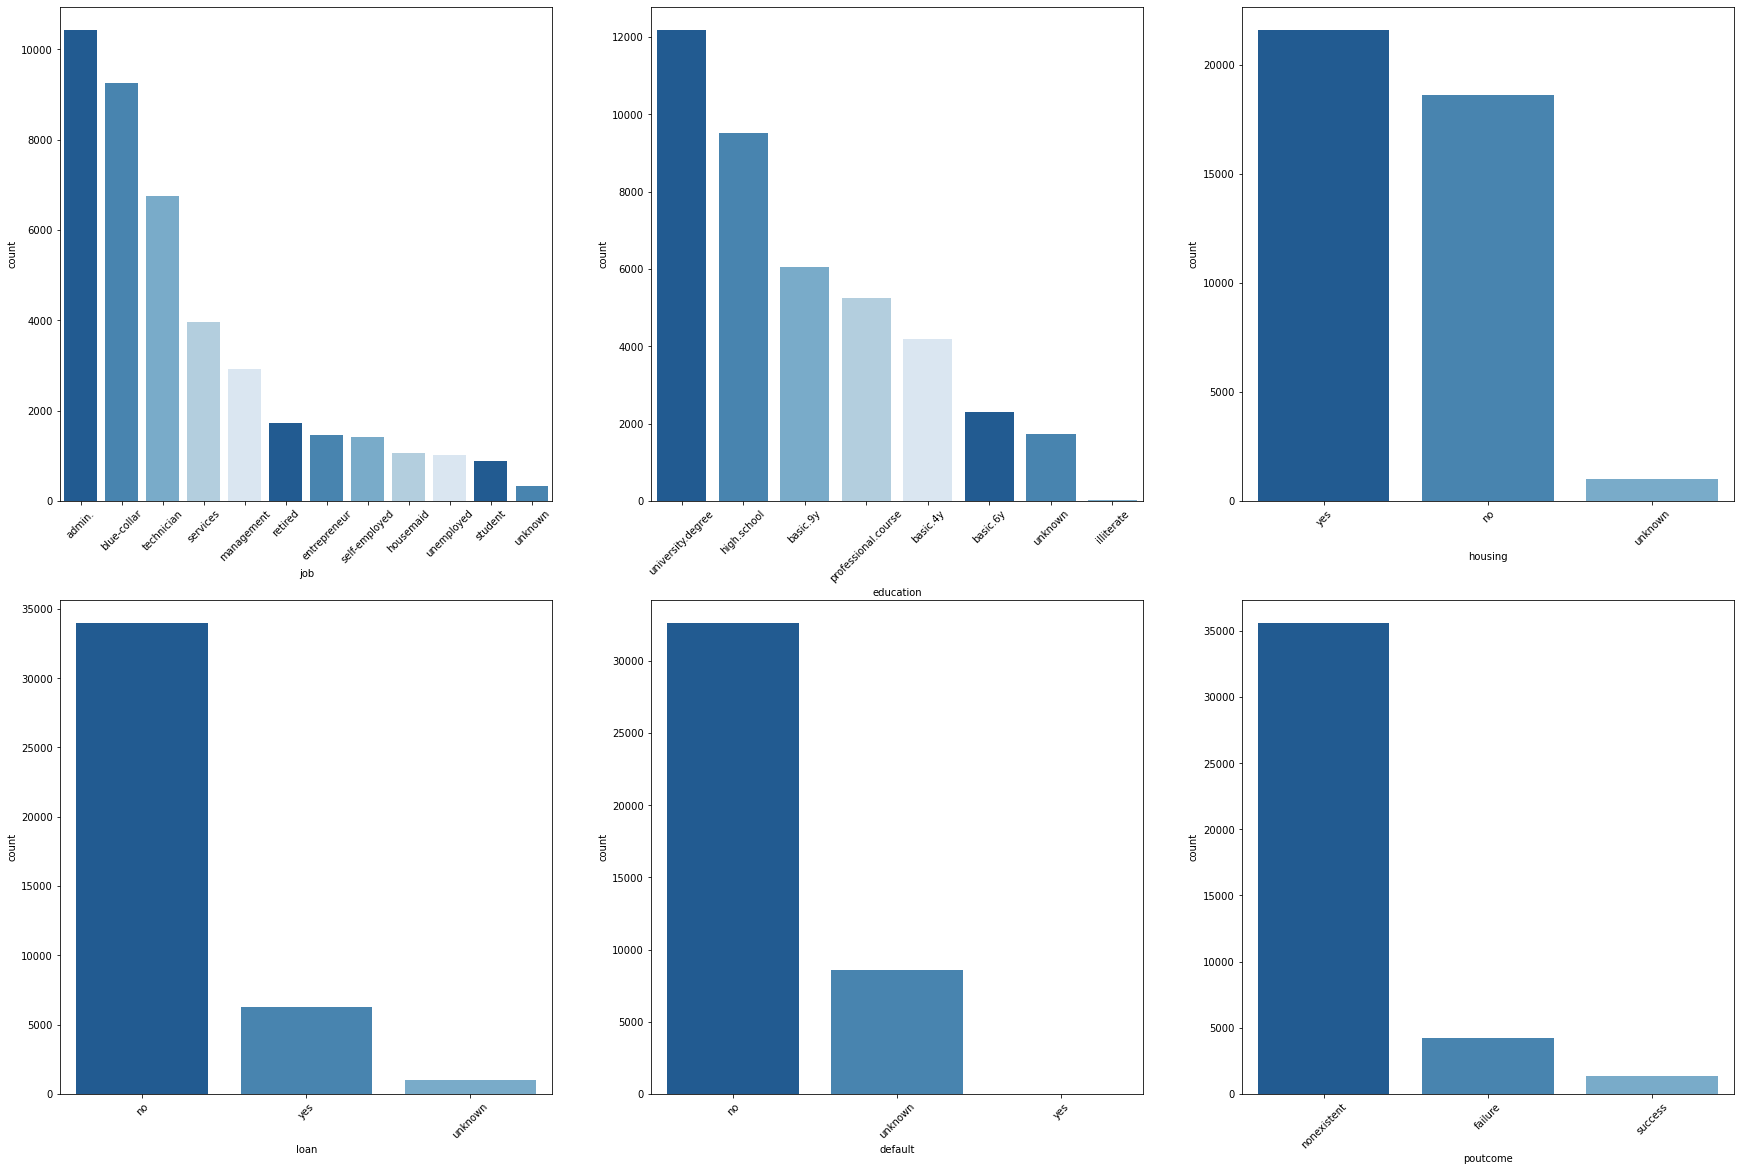

In [14]:
# Counting values of categories within each categorical column
fig, axes = plt.subplots(2, 3, figsize = (30, 20))

cp = sns.color_palette('Blues_r', 5)
s1 = sns.countplot(x = 'job', data = bank_df, ax = axes[0, 0], palette = cp, order = bank_df['job'].value_counts().index)
s1.set_xticklabels(s1.get_xticklabels(), rotation = 45)
s2 = sns.countplot(x = 'education', data = bank_df, ax = axes[0, 1], palette = cp, order = bank_df['education'].value_counts().index)
s2.set_xticklabels(s2.get_xticklabels(), rotation = 45)
s3 = sns.countplot(x = 'housing', data = bank_df, ax = axes[0, 2], palette = cp, order = bank_df['housing'].value_counts().index)
s3.set_xticklabels(s3.get_xticklabels(), rotation = 45)
s4 = sns.countplot(x = 'loan', data = bank_df, ax = axes[1, 0], palette = cp, order = bank_df['loan'].value_counts().index)
s4.set_xticklabels(s4.get_xticklabels(), rotation = 45)
s5 = sns.countplot(x = 'default', data = bank_df, ax = axes[1, 1], palette = cp, order = bank_df['default'].value_counts().index)
s5.set_xticklabels(s5.get_xticklabels(), rotation = 45)
s6 = sns.countplot(x = 'poutcome', data = bank_df, ax = axes[1, 2], palette = cp, order = bank_df['poutcome'].value_counts().index)
s6.set_xticklabels(s6.get_xticklabels(), rotation = 45)
None

**From the above univariate analysis we can see that majority people are in admin, blue-collar and technician job categories which usually pay less compared to white collar jobs, are educated i.e. have obtained university-level or high school degrees, have housing loans, and who are not likely to default on loans.**

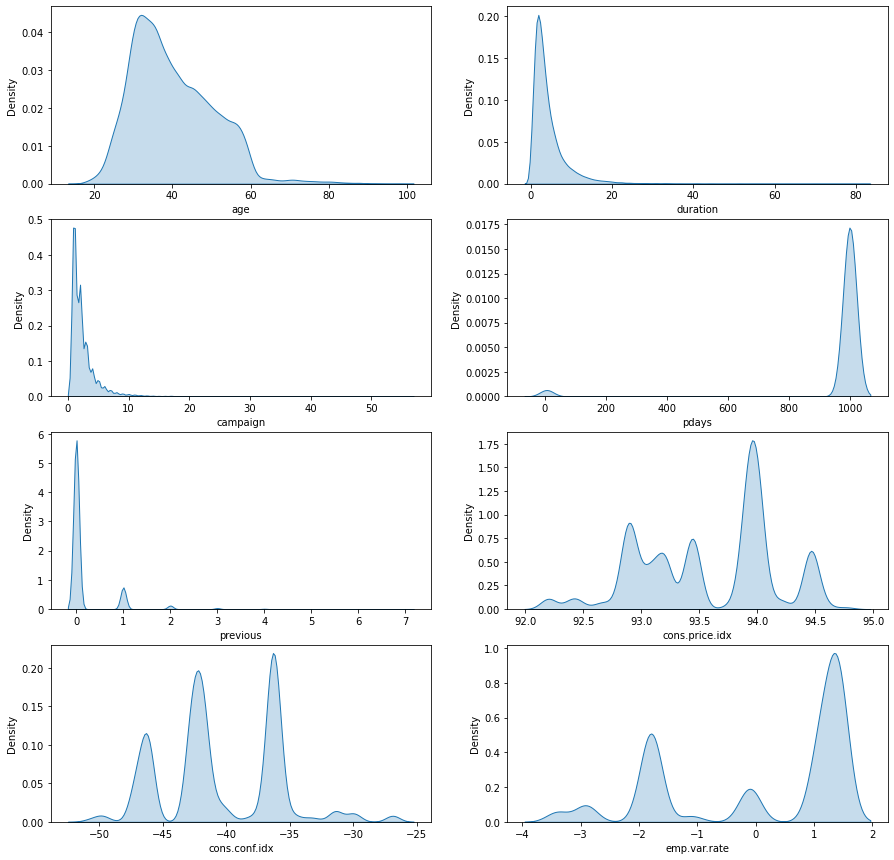

In [ ]:
# Density plot for distribution of continuous columns
fig, axes = plt.subplots(4, 2, figsize = (15, 15))

n1 = sns.kdeplot(bank_df['age'], fill = True, ax = axes[0, 0], palette = cp)
n2 = sns.kdeplot(bank_df['duration'], fill = True, ax = axes[0, 1], palette = cp)
n2 = sns.kdeplot(bank_df['campaign'], fill = True, ax = axes[1, 0], palette = cp)
n2 = sns.kdeplot(bank_df['pdays'], fill = True, ax = axes[1, 1], palette = cp)
n2 = sns.kdeplot(bank_df['previous'], fill = True, ax = axes[2, 0], palette = cp)
n2 = sns.kdeplot(bank_df['cons.price.idx'], fill = True, ax = axes[2, 1], palette = cp)
n2 = sns.kdeplot(bank_df['cons.conf.idx'], fill = True, ax = axes[3, 0], palette = cp)
n2 = sns.kdeplot(bank_df['emp.var.rate'], fill = True, ax = axes[3, 1], palette = cp)

**Density plots are used for the numerical/continuous features to check the distribution of the dataset and the feature pdays seem to be efficient for classifying the output as we can see the clear distinction between output categories.**

### Checking for Outliers

<AxesSubplot:xlabel='emp.var.rate'>

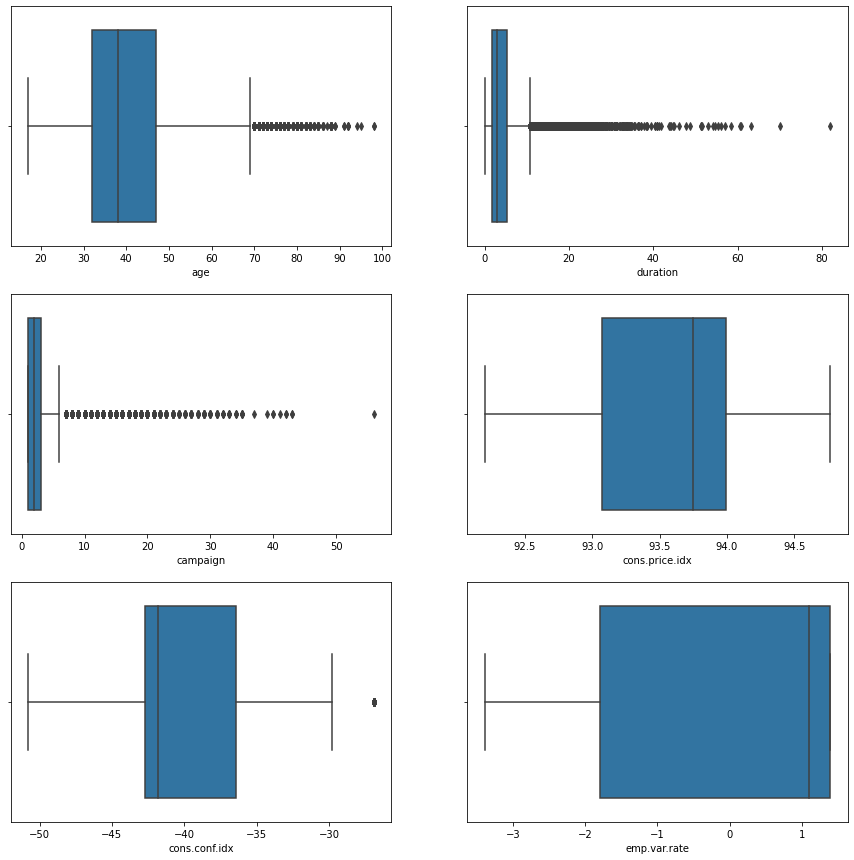

In [15]:
# Plotting outliers in continuous columns
fig, axes = plt.subplots(3, 2, figsize = (15, 15))

sns.boxplot(x = 'age', data = bank_df, ax = axes[0, 0])
sns.boxplot(x = 'duration', data = bank_df, ax = axes[0, 1])
sns.boxplot(x = 'campaign', data = bank_df, ax = axes[1, 0])
sns.boxplot(x = 'cons.price.idx', data = bank_df, ax = axes[1, 1])
sns.boxplot(x = 'cons.conf.idx', data = bank_df, ax = axes[2, 0])
sns.boxplot(x = 'emp.var.rate', data = bank_df, ax = axes[2, 1])

From the above boxplots, we can see that there are outliers in the dataset.

## Bivariate/ Multivariate Analysis

<AxesSubplot:>

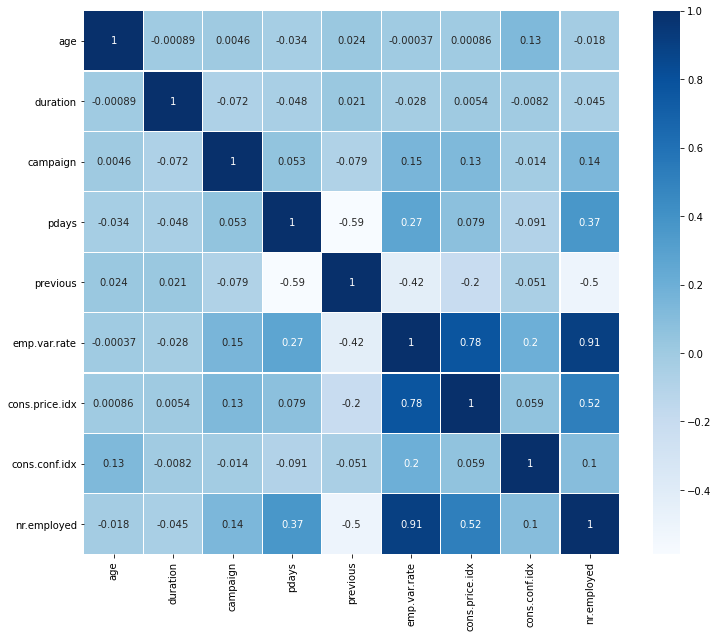

In [16]:
# Correlation map showing numerical association between numerical columns
plt.figure(figsize = (12, 10))
sns.heatmap(bank_df.corr(), annot = True, cmap = 'Blues', linewidth = 0.1, annot_kws = {'size': 10})

**From this correlation plot, we can see that there is high correlation between nr.employed and emp.var.rate which is 0.91. And, in general between all the economic features that describe the confidence users have on the financial situation of the economy.**

## Multivariate Analysis

In [17]:
num_cols = ['age', 'duration', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'y']

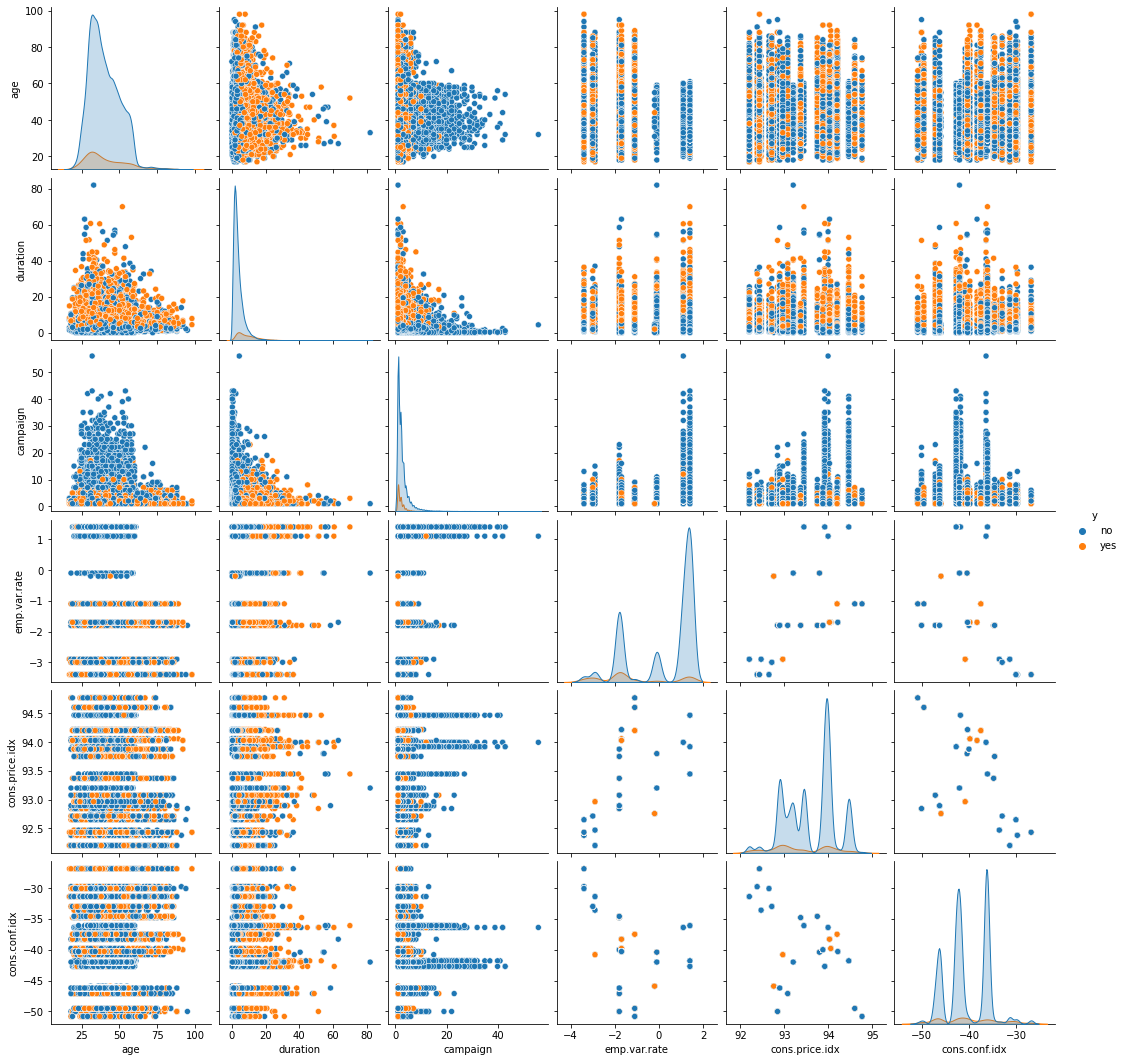

In [18]:
# Scatter Matrix for exploring linear/non-linear relation between numerical columns
sns.pairplot(bank_df[num_cols], hue = 'y')

**Most of the features have overlapping data which is difficult to pictorially identify which features are important for feature selection. But few columns like cons.price.idx , emp.var.rate, cons.price.idx doesn't have operlapping points which could be important for classification.**

## Data Processing & Feature Selection

In [19]:
# Creating temporary dataframe to
temp_df = bank_df.copy()

**Retaining the original data before processing**

In [20]:
# Getting numerical columns
num_cols = temp_df.select_dtypes(include = ['int64', 'float64']).columns.tolist()

# Applying standardization
preprocessor = StandardScaler()
temp_df[num_cols] = preprocessor.fit_transform(temp_df[num_cols])

temp_df.head()

,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,y
0,1.533034,housemaid,married,basic.4y,no,no,no,telephone,may,0.021982,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.33168,no
1,1.628993,services,married,high.school,unknown,no,no,telephone,may,-0.417679,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.33168,no
2,-0.290186,services,married,high.school,no,yes,no,telephone,may,-0.116859,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.33168,no
3,-0.002309,admin.,married,basic.6y,no,no,no,telephone,may,-0.417679,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.33168,no
4,1.533034,services,married,high.school,no,no,yes,telephone,may,0.183962,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.33168,no


**Standardizing the numerical features as there are outliers using standardscaler function to bring the values to same scale.**

In [21]:
# Performing label encoding for categorical columns
le = LabelEncoder()

temp_df['job'] = le.fit_transform(temp_df['job'])
temp_df['marital'] = le.fit_transform(temp_df['marital'])
temp_df['default'] = le.fit_transform(temp_df['default'])
temp_df['housing'] = le.fit_transform(temp_df['housing'])
temp_df['loan'] = le.fit_transform(temp_df['loan'])
temp_df['contact'] = le.fit_transform(temp_df['contact'])
temp_df['month'] = le.fit_transform(temp_df['month'])
temp_df['poutcome'] = le.fit_transform(temp_df['poutcome'])
temp_df['education'] = le.fit_transform(temp_df['education'])

**Performing label encoding to categorical variables as the random classifier needs the encoding of categorical features for feature selection.**

In [22]:
# Temporary transformed data
temp_df.head()

,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,y
0,1.533034,3,1,0,0,0,0,1,6,0.021982,-0.565922,0.195414,-0.349494,1,0.648092,0.722722,0.886447,0.33168,no
1,1.628993,7,1,3,1,0,0,1,6,-0.417679,-0.565922,0.195414,-0.349494,1,0.648092,0.722722,0.886447,0.33168,no
2,-0.290186,7,1,3,0,2,0,1,6,-0.116859,-0.565922,0.195414,-0.349494,1,0.648092,0.722722,0.886447,0.33168,no
3,-0.002309,0,1,1,0,0,0,1,6,-0.417679,-0.565922,0.195414,-0.349494,1,0.648092,0.722722,0.886447,0.33168,no
4,1.533034,7,1,3,0,0,2,1,6,0.183962,-0.565922,0.195414,-0.349494,1,0.648092,0.722722,0.886447,0.33168,no


In [23]:
# Selecting top 10 features with random forest
rf = RandomForestClassifier(random_state = 2)
rf.fit(temp_df.iloc[:, :-1], temp_df.iloc[:, -1])

imp = rf.feature_importances_
sorted_features = sorted(zip(imp, temp_df), reverse=True)

features = []
for importance, feature in sorted_features[:10]:
    features.append(feature)
    print("{}: {}".format(feature, importance))

duration: 0.33964363067737285
age: 0.1228150357969828
nr.employed: 0.07078576071029186
job: 0.05976229831887635
education: 0.052798672111817505
campaign: 0.052232471710653525
pdays: 0.04765881365148876
cons.conf.idx: 0.04000331517782479
emp.var.rate: 0.03613846159141192
marital: 0.028879463887879656


**We got the top 10 importnat features efficient for classification using Random Forest Classifier, which is a a powerful ensemble technique that can be used for feature selection by assessing the importance of each feature in the context of predictive performance. The algorithm assigns scores to features based on its contribution ot reducing impurity which is measured as Gini Index across decision trees. We can select the important fetaures based on these scores by limiting on the number of features for modelling or by having some threshold value to select important features. This reduces the dimensionality of the dataset without loosing much information for classifying the ouput.**


**We can see that the top most important features are duration, age, nr.emploed, job, education, campaign, pdays, cons.conf.idx, emp.var.rate, marital.**

In [24]:
# Choosing columns of interest from original dataframe
cols_to_keep = ['duration', 'age', 'nr.employed', 'job', 'emp.var.rate', 'education', 'campaign', 'cons.conf.idx', 'marital', 'pdays', 'y']
cols_to_drop = set(bank_df.columns).intersection(cols_to_keep)
bank_df.drop(columns = set(bank_df.columns) - cols_to_drop, axis = 1, inplace = True)

**Dropping the other features in the dataset, except the most 10 important features we got through the classifier.**

In [25]:
bank_df.head()

,age,job,marital,education,duration,campaign,pdays,emp.var.rate,cons.conf.idx,nr.employed,y
0,56,housemaid,married,basic.4y,4.4,1,999,1.1,-36.4,5191.0,no
1,57,services,married,high.school,2.5,1,999,1.1,-36.4,5191.0,no
2,37,services,married,high.school,3.8,1,999,1.1,-36.4,5191.0,no
3,40,admin.,married,basic.6y,2.5,1,999,1.1,-36.4,5191.0,no
4,56,services,married,high.school,5.1,1,999,1.1,-36.4,5191.0,no


In [26]:
# Splitting df
X = bank_df.iloc[:, :-1]
y = pd.DataFrame(bank_df.iloc[:, -1], columns = ['y'])

In [27]:
# Getting numerical and categorical columns for original
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Creating a column tranformer to implement one hot encoding and standardization
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

# Fitting the column tranformer on original data
processed_data = preprocessor.fit_transform(X)

# Creating a new dataframe with the processed data
new_bank_df = pd.DataFrame(
    processed_data,
    columns = num_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
)

**Standardizing the numerical columns and encoding categorical features using One-Hot encoding.**

In [28]:
# Final dataframe with preprocessing
new_bank_df.head()

,age,duration,campaign,pdays,emp.var.rate,cons.conf.idx,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown
0,1.533034,0.021982,-0.565922,0.195414,0.648092,0.886447,0.33168,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.628993,-0.417679,-0.565922,0.195414,0.648092,0.886447,0.33168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.290186,-0.116859,-0.565922,0.195414,0.648092,0.886447,0.33168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.002309,-0.417679,-0.565922,0.195414,0.648092,0.886447,0.33168,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.533034,0.183962,-0.565922,0.195414,0.648092,0.886447,0.33168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [29]:
# Performing label encoding on y before applying SMOTE
# no = 0, yes = 1
le1 = LabelEncoder()
y['y'] = le1.fit_transform(y['y'])

In [30]:
# SMOTE technique for handling imbalanaced data
smote = SMOTE(random_state = 2)
bank_df_b, y_train_b = smote.fit_resample(new_bank_df, y)

**Synthetic Minority Oversampling technique (SMOTE) is an oversampling technique used for imbalanced datasets where number of instances of one class (majority class) outweighs other class (minority class) significantly. These imbalanced datasets perform well on the tarin datasets, but badly on test dataset/new data point as the algorithm cannot learn the patterns of minority class. SMOTE aims to mitigate this issue by oversampling the minority class datasets by creating the synthetic samples that are similar to records of minority class and helps to prevent overfitting of the model.**

In [31]:
# Balanced dataframe
bank_df_b.head()

,age,duration,campaign,pdays,emp.var.rate,cons.conf.idx,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown
0,1.533034,0.021982,-0.565922,0.195414,0.648092,0.886447,0.33168,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.628993,-0.417679,-0.565922,0.195414,0.648092,0.886447,0.33168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.290186,-0.116859,-0.565922,0.195414,0.648092,0.886447,0.33168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.002309,-0.417679,-0.565922,0.195414,0.648092,0.886447,0.33168,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.533034,0.183962,-0.565922,0.195414,0.648092,0.886447,0.33168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
y_train_b['y'].value_counts()

1    36548
0    36548
Name: y, dtype: int64

## Model Implementation & Evaluation

In [32]:
# Splitting imbalanced data into 70-30 sets for train-test
new_bank_df['y'] = y['y']

new_bank_df['split'] = np.random.randn(new_bank_df.shape[0], 1)
msk = np.random.rand(len(new_bank_df)) <= 0.7
train = new_bank_df[msk]
test = new_bank_df[~msk]

train.drop('split', axis = 1, inplace = True)
test.drop('split', axis = 1, inplace = True)

In [33]:
# Splitting balanced data into 70-30 sets for train-test
bank_df_b['y'] = y_train_b['y']

bank_df_b['split'] = np.random.randn(bank_df_b.shape[0], 1)
msk = np.random.rand(len(bank_df_b)) <= 0.7
train_b = bank_df_b[msk]
test_b = bank_df_b[~msk]

train_b.drop('split', axis = 1, inplace = True)
test_b.drop('split', axis = 1, inplace = True)

**Splitting the imbalanced and balanced datasets into train and test datasets in the ratio of 70 and 30 percent respectively for training and testing the model.**

In [34]:
# Resetting index of test data
train.reset_index(inplace = True)
train.drop('index', axis = 1, inplace = True)

test.reset_index(inplace = True)
test.drop('index', axis = 1, inplace = True)

train_b.reset_index(inplace = True)
train_b.drop('index', axis = 1, inplace = True)

test_b.reset_index(inplace = True)
test_b.drop('index', axis = 1, inplace = True)

### Logistic Regression with Imbalanced Data

In [ ]:
class LogisticRegression:

    def __init__ (self, X, y, learning_rate, tolerance, max_iteration):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.max_iteration = max_iteration

    def read_data(self):
        X, y = np.array(self.X, dtype = np.float64), np.array(self.y, dtype = np.float64)

        self.X_train = X[:, :-1]
        self.y_train = X[:, -1]
        self.X_test = y[:, :-1]
        self.y_test = y[:, -1]

        return self.X_train, self.X_test, self.y_train, self.y_test

    def addX0(self,X):
        return np.column_stack([np.ones(X.shape[0], 1), X])

    def sigmoid(self, z):
        s = 1 / (1 + np.exp(-z))
        return s

    def cost_function(self, X, y):
        p_yi = self.sigmoid(X.dot(self.theta))
        cost = (1/X.shape[0]) * y.dot(np.log(p_yi) + (1 - y).dot(np.log(1-p_yi)))
        return - cost.sum()


    def cost_derivative(self, X, y):
        s = self.sigmoid(X.dot(self.theta))
        grad = (s - y).dot(X)
        return grad

    def gradient_descent(self, X, y):
        errors = []
        prev_error = float('inf')

        for i in tqdm(range(self.max_iteration), colour = 'red'):
            self.theta -=  self.learning_rate * self.cost_derivative(X, y)
            error = self.cost_function(X, y)
            errors.append(error)

            if abs(prev_error - error) < self.tolerance:
                print('Stopped Learning')
                break
            prev_error = error

        self.plot_cost(errors)

    def predict(self, X):
        s = self.sigmoid(X.dot(self.theta))
        return np.around(s)

    def plot_cost(self, cost_sequence):
        s = np.array(cost_sequence)
        t = np.arange(s.size)
        plt.plot(t, s)
        plt.xlabel('Cost')
        plt.ylabel('Iterations')
        plt.title('Cost Trend')

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.read_data()
        self.theta = np.ones(self.X_train.shape[1], dtype = np.float64) * 0

        cost_sequences = self.gradient_descent(self.X_train, self.y_train)
        print(self.theta)

        y_cap = self.predict(self.X_train)
        self.plot_cost(cost_sequences)

        y_cap_test = self.predict(self.X_test)

        return self.y_test, y_cap_test

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 594.14it/s]


[ 0.0043248   1.16275394 -0.11732957 -0.28746259 -0.31371849  0.10731363
 -0.67695759 -0.42350209 -0.96793947 -0.46074345 -0.28819789 -0.43582436
 -0.21716379 -0.38249    -0.65370711 -0.2046016  -0.50115019 -0.26726451
 -0.12062699 -1.53810599 -1.72349892 -1.52537156 -0.13623497 -0.72757891
 -0.58775161 -0.85400181 -0.91794968  0.00822703 -0.67470266 -0.65751528
 -0.51193853]


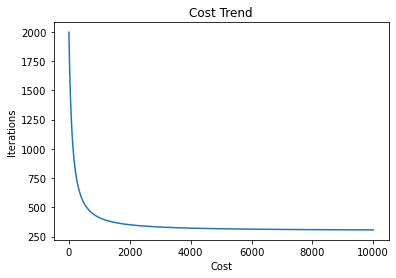

In [ ]:
lr = LogisticRegression(X = train, y = test, learning_rate = 0.1e-5, tolerance = 0.000001 , max_iteration = 10000)
actual_lr, pred_lr = lr.fit()

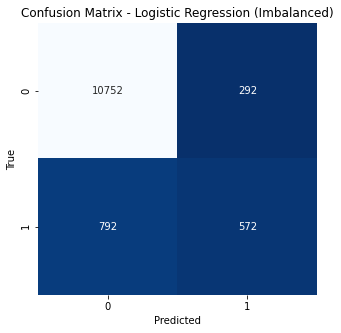

In [ ]:
# Plotting confusion matrix
cm_lr = confusion_matrix(actual_lr, pred_lr)
plt.figure(figsize = (5, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues_r", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression (Imbalanced)")
plt.show()

In [ ]:
# Printing evaluation metrics
acc_lr = accuracy_score(actual_lr, pred_lr)
f1_lr = f1_score(actual_lr, pred_lr)
pre_lr = precision_score(actual_lr, pred_lr)
rec_lr = recall_score(actual_lr, pred_lr)
roc_auc_lr = roc_auc_score(actual_lr, pred_lr)

print('Accuracy: {:.2f}'.format(acc_lr))
print('F1 Score: {:.2f}'.format(f1_lr))
print('Precision: {:.2f}'.format(pre_lr))
print('Recall: {:.2f}'.format(rec_lr))
print('ROC_AUC_Score: {:.2f}'.format(roc_auc_lr))

Accuracy: 0.91
F1 Score: 0.51
Precision: 0.66
Recall: 0.42
ROC_AUC_Score: 0.70


**The evaluation metrics used are Accuracy, F1 Score , Precision, Recall and AUC-ROC scores.**

**Accuracy - It gives the overall correctness of a model and it tells us how many values are correctly classified among the predicted ones.It is calculated from -**

Accuracy = [TP + TN]/[TP+TN+FP+FN]

**Since it can classify most of the majority class points correctly, it is not the accurate metric to evaluate model on imbalance datasets.**

**Precision - Precision gives the information about how many points  predicted as class of interest actually belongs to the class of interest and can be calculated from the following formula -**

Precision = [ TP]/[TP+ FP]

**Recall - Recall gives the information about how many points from the class of interest are correctly classified among all the actual  number of points from the class of interest and calculated as follows -**

Recall = [TP]/[TP+FN]

**F1-Score - It is the harmonic mean of precision and recall and is the balance between both the metrics and can be defined as -**

F1-score = [1/Precision] + [1/Recall]

**AUC-ROC score - It assesses the models abilty to discriminate between majority class and minory class instances correctly across different thresholds. A higher value indicates the better performance.**


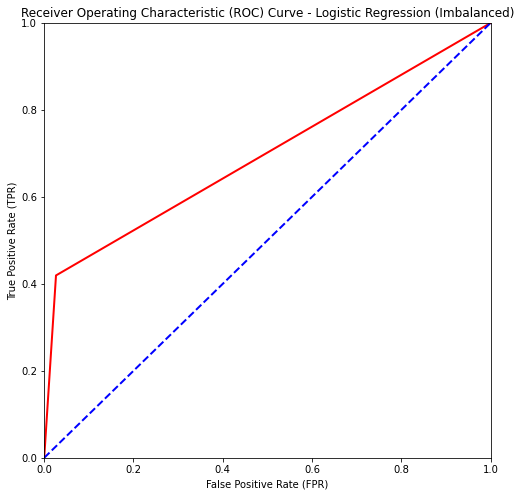

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(actual_lr, pred_lr)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression (Imbalanced)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

### Logistic Regression with Balanced Data

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 274.39it/s]


[-0.01273842  1.83886838 -0.2042982  -0.29672808 -0.6313161   0.06069678
 -0.65344182 -0.17098589 -0.67355042 -0.59356349 -0.29476798 -0.41741911
  0.53163118 -0.38703749 -0.60722888  0.30304512 -0.16158518 -0.05551635
 -0.11984584 -0.90029262 -0.83905693 -0.77123836 -0.13623643 -0.46684302
 -0.62401531 -0.55856255 -0.42617071  0.01500889 -0.25680901 -0.0222766
 -0.30715603]


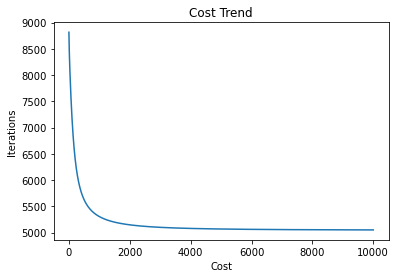

In [ ]:
lr = LogisticRegression(X = train_b, y = test_b, learning_rate = 0.1e-5, tolerance = 0.000001 , max_iteration = 10000)
actual_b_lr, pred_b_lr = lr.fit()

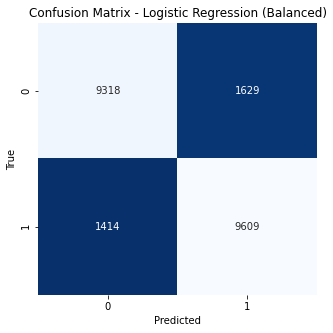

In [ ]:
cm_b_lr = confusion_matrix(actual_b_lr, pred_b_lr)
plt.figure(figsize = (5, 5))
sns.heatmap(cm_b_lr, annot=True, fmt="d", cmap="Blues_r", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression (Balanced)")
plt.show()

In [ ]:
acc_b_lr = accuracy_score(actual_b_lr, pred_b_lr)
f1_b_lr = f1_score(actual_b_lr, pred_b_lr)
pre_b_lr = precision_score(actual_b_lr, pred_b_lr)
rec_b_lr = recall_score(actual_b_lr, pred_b_lr)
roc_auc_b_lr = roc_auc_score(actual_b_lr, pred_b_lr)

print('Accuracy: {:.2f}'.format(acc_b_lr))
print('F1 Score: {:.2f}'.format(f1_b_lr))
print('Precision: {:.2f}'.format(pre_b_lr))
print('Recall: {:.2f}'.format(rec_b_lr))
print('ROC_AUC_Score: {:.2f}'.format(roc_auc_b_lr))

Accuracy: 0.86
F1 Score: 0.86
Precision: 0.86
Recall: 0.87
ROC_AUC_Score: 0.86


**We can see that accuracy of the model is less and for the balanced compared to that that of imbalanced dataset which indicated the  the balanced dataset tends to reduce the overfitting and has better performance as precision, recall and area under curve are high.**

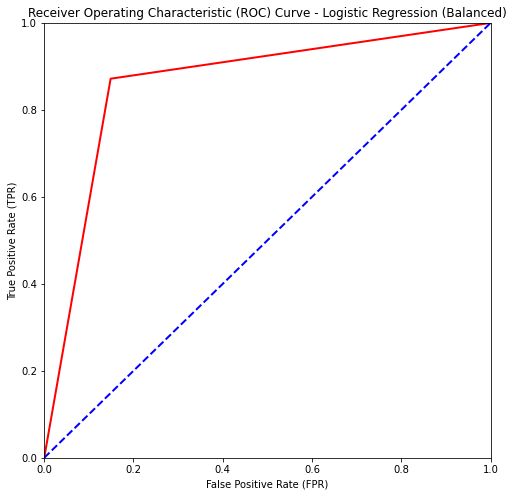

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(actual_b_lr, pred_b_lr)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression (Balanced)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

### Gaussian Naive Bayes with Imbalanced Data

In [ ]:
class GaussianNB:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def dataSplit(self):
        X, y = np.array(self.X, dtype = np.float64), np.array(self.y, dtype = np.float64)
        self.X_train = self.X.iloc[:, :-1].values
        self.y_train = self.X.iloc[:, -1].values
        self.X_test = self.y.iloc[:, :-1].values
        self.y_test = self.y.iloc[:, -1].values
        return self.X_train, self.X_test, self.y_train, self.y_test

    def fitDistribution(self, X):
        mean = np.mean(X)
        std = np.std(X)
        dist = norm(mean, std)
        return dist

    def posterior(self, X, dist, prior):
        p = prior
        cnt = 0
        for idx, dis in enumerate(dist):
            p = p * dis.pdf(X[idx])
        return p

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.dataSplit()

        X0 = self.X_train[self.y_train == 0]
        X1 = self.X_train[self.y_train == 1]

        self.prior_0 = X0.shape[0] / self.X_train.shape[0]
        self.prior_1 = X1.shape[0] / self.X_train.shape[0]

        self.dist_0 = [self.fitDistribution(X0[:, i]) for i in range(31)]
        self.dist_1 = [self.fitDistribution(X1[:, i]) for i in range(31)]

    def predict(self):
        y_pred = []

        for rec, y in zip(self.X_test, self.y_test):
            p_y0 = self.posterior(rec, self.dist_0, self.prior_0)
            p_y1 = self.posterior(rec, self.dist_1, self.prior_1)

            pred_val = np.argmax([p_y0, p_y1])
            y_pred.append(pred_val)
            print('Model predicted class {} and data was class {}'.format(pred_val, y))
        return y_pred

In [ ]:
actual_nb = test.iloc[:, -1]

nb = GaussianNB(train, test)
nb.fit()
pred_nb = nb.predict()

Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 1 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 1 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 1 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model pred

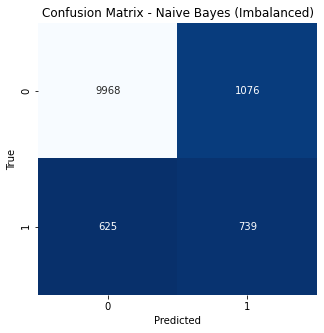

In [ ]:
cm_nb = confusion_matrix(actual_nb, pred_nb)
plt.figure(figsize = (5, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues_r", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Naive Bayes (Imbalanced)")
plt.show()

In [ ]:
acc_nb = accuracy_score(actual_nb, pred_nb)
f1_nb = f1_score(actual_nb, pred_nb)
pre_nb = precision_score(actual_nb, pred_nb)
rec_nb = recall_score(actual_nb, pred_nb)
roc_auc_nb = roc_auc_score(actual_nb, pred_nb)

print('Accuracy: {:.2f}'.format(acc_nb))
print('F1 Score: {:.2f}'.format(f1_nb))
print('Precision: {:.2f}'.format(pre_nb))
print('Recall: {:.2f}'.format(rec_nb))
print('ROC_AUC_Score: {:.2f}'.format(roc_auc_nb))

Accuracy: 0.86
F1 Score: 0.46
Precision: 0.41
Recall: 0.54
ROC_AUC_Score: 0.72


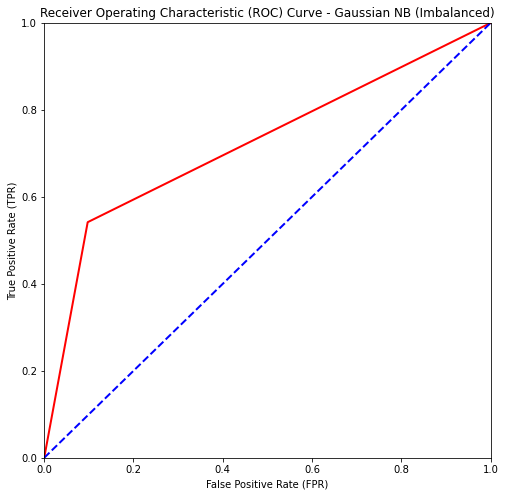

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(actual_nb, pred_nb)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gaussian NB (Imbalanced)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

### Gaussian Naive Bayes with Balanced Data

In [ ]:
actual_b_nb = test_b.iloc[:, -1]

nb = GaussianNB(train_b, test_b)
nb.fit()
pred_b_nb = nb.predict()

Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 1 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model predicted class 0 and data was class 0
Model pred

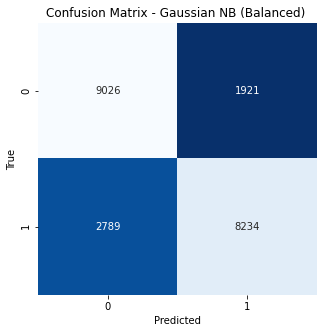

In [ ]:
cm_b_nb = confusion_matrix(actual_b_nb, pred_b_nb)
plt.figure(figsize = (5, 5))
sns.heatmap(cm_b_nb, annot=True, fmt="d", cmap="Blues_r", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Gaussian NB (Balanced) ")
plt.show()

In [ ]:
acc_b_nb = accuracy_score(actual_b_nb, pred_b_nb)
f1_b_nb = f1_score(actual_b_nb, pred_b_nb)
pre_b_nb = precision_score(actual_b_nb, pred_b_nb)
rec_b_nb = recall_score(actual_b_nb, pred_b_nb)
roc_auc_b_nb = roc_auc_score(actual_b_nb, pred_b_nb)

print('Accuracy: {:.2f}'.format(acc_b_nb))
print('F1 Score: {:.2f}'.format(f1_b_nb))
print('Precision: {:.2f}'.format(pre_b_nb))
print('Recall: {:.2f}'.format(rec_b_nb))
print('ROC_AUC_Score: {:.2f}'.format(roc_auc_b_nb))

Accuracy: 0.79
F1 Score: 0.78
Precision: 0.81
Recall: 0.75
ROC_AUC_Score: 0.79


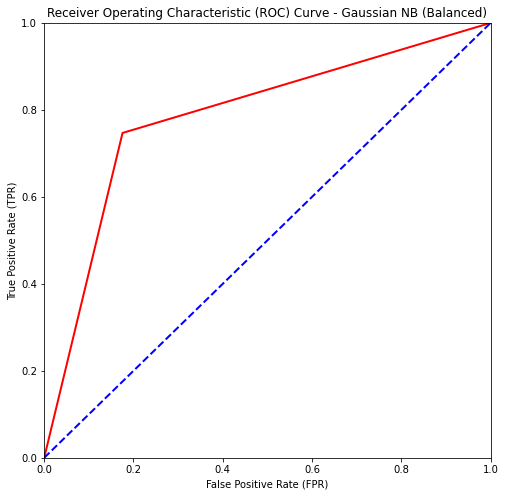

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(actual_b_nb, pred_b_nb)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gaussian NB (Balanced)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

**Similar pattern as logistic regress is observed for Naive bayes where the model performs better with balanced dataset than the imbalanced dataset and the area under cuver significantly varies for balanced and imbalance datasets which the best indicator of model performance.**

### Support Vector Machines with Imbalanced Data

In [ ]:
class softmarginSVM:
    c:float
    def __init__(self,c):
        self.alphas = None
        self.w =None
        self.b = None
        self.support_vectors = None
        self.support_labels= None
        self.c=c

    def dualSVM(self, gramXY, alphas):
        return alphas.sum()-0.5 * alphas.dot(alphas.dot(gramXY))

    def jacobian_dualSVM(self, gramXY, alphas):
        return np.ones(len(alphas)) - alphas.dot(gramXY)

    def fit(self, X, y):
        N,n_features = X.shape
        y_ = np.where(y<= 0, -1, 1)
        A=np.vstack((-np.eye(N),np.eye(N)))
        self.b=np.concatenate((np.zeros(N),self.c*np.ones(N)))
        Xy = X * y_[:, np.newaxis]
        gramXY= Xy.dot(Xy.T)

        alphas = np.ones(N)

        bounds = Bounds(np.zeros(N), np.full(N, self.c))
        constraints = ({'type':'eq','fun':lambda a:np.dot(a, y_), 'jac':lambda a:y_},
                       {'type':'ineq','fun':lambda a:self.b-np.dot(a, y_), 'jac':lambda a:-A})


        slsqp = minimize(fun = lambda a:-self.dualSVM(gramXY, a),x0 = alphas, jac = lambda a:-self.jacobian_dualSVM(gramXY, a),constraints = constraints, method = 'SLSQP')

        self.alphas = slsqp.x
        self.w = np.sum((self.alphas[:, np.newaxis]*Xy), axis = 0)
        epsilon = 1e-6
        self.support_vectors = X[self.alphas > epsilon]
        signdist = np.matmul(self.support_vectors, self.w)
        mindist = np.argmin(signdist)
        self.support_labels = y_[self.alphas > epsilon]
        #for i in range(len(self.support_labels)):
          #b_i = self.support_labels[i] - np.matmul(self.support_vectors[i].T,self.w)
          #self.b.append(b_i)
        #self.b = sum(self.b)/len(self.b)
        self.b = np.mean(self.support_labels - np.matmul(self.support_vectors, self.w))

    def predict(self,X):
        y_pred = 2*(np.matmul(X,self.w)+self.b>0)-1
        return y_pred

In [ ]:
sample_size = 1000
sampled_df = new_bank_df.sample(n=sample_size, random_state=2)

# Display the sampled DataFrame
sampled_df.shape

(1000, 33)

In [ ]:
sampled_df.drop('split', axis = 1, inplace = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sampled_df.iloc[:,:-1], sampled_df.iloc[:,-1], test_size = 0.3, random_state = 2)

In [ ]:
y_train.replace(0,-1)

688     -1
6068    -1
21967   -1
17336   -1
39254   -1
        ..
29098   -1
33882   -1
10177   -1
24603   -1
17870   -1
Name: y, Length: 700, dtype: int32

In [ ]:
model_SVM = softmarginSVM(c = 10)
model_SVM.fit(X_train.to_numpy(), y_train.to_numpy())

In [ ]:
predicted_SVM = model_SVM.predict(X_test.to_numpy())
#predicted = predicted.replace(-1,0)
predicted_SVM[predicted_SVM == -1] = 0

In [ ]:
y_test.head()

12985    0
9039     0
28575    0
27824    1
4778     0
Name: y, dtype: int32

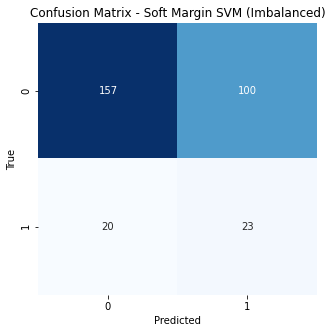

In [ ]:
cm_SVM = confusion_matrix(y_test, predicted_SVM)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_SVM, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Soft Margin SVM (Imbalanced)")
plt.show()

In [ ]:
acc_SVM = accuracy_score(y_test, predicted_SVM)
f1_SVM = f1_score(y_test, predicted_SVM)
pre_SVM = precision_score(y_test, predicted_SVM)
rec_SVM = recall_score(y_test, predicted_SVM)
roc_auc_SVM = roc_auc_score(y_test, predicted_SVM)

print('Accuracy: {:.2f}'.format(acc_SVM))
print('F1 Score: {:.2f}'.format(f1_SVM))
print('Precision: {:.2f}'.format(pre_SVM))
print('Recall: {:.2f}'.format(rec_SVM))
print('ROC_AUC_Score: {:.2f}'.format(roc_auc_SVM))

Accuracy: 0.60
F1 Score: 0.28
Precision: 0.19
Recall: 0.53
ROC_AUC_Score: 0.57


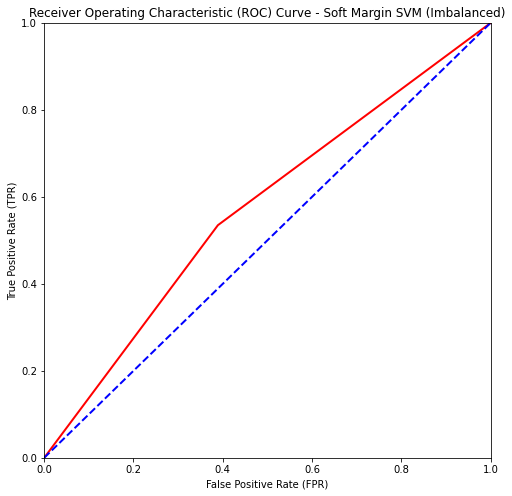

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, predicted_SVM)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Soft Margin SVM (Imbalanced)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

### Support Vector Machine with Balanced Data

In [ ]:
sample_size = 1000
sampled_df_b = bank_df_b.sample(n = sample_size, random_state = 2)

# Display the sampled DataFrame
sampled_df_b.shape

(1000, 33)

In [ ]:
sampled_df_b.drop('split', axis = 1, inplace = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sampled_df_b.iloc[:,:-1], sampled_df_b.iloc[:,-1], test_size = 0.3, random_state = 2)

In [ ]:
y_train.replace(0,-1)

14891   -1
52831    1
55744    1
15418   -1
15647   -1
        ..
68168    1
60948    1
29523    1
16099   -1
47145    1
Name: y, Length: 700, dtype: int32

In [ ]:
model_b_SVM = softmarginSVM(c = 10)
model_b_SVM.fit(X_train.to_numpy(), y_train.to_numpy())

In [ ]:
predicted_b_SVM = model_b_SVM.predict(X_test.to_numpy())
#predicted = predicted.replace(-1,0)
predicted_b_SVM[predicted_b_SVM == -1] = 0

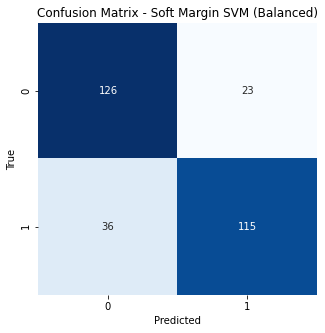

In [ ]:
cm_b_SVM = confusion_matrix(y_test, predicted_b_SVM)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_b_SVM, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Soft Margin SVM (Balanced)")
plt.show()

In [ ]:
acc_b_SVM = accuracy_score(y_test, predicted_b_SVM)
f1_b_SVM = f1_score(y_test, predicted_b_SVM)
pre_b_SVM = precision_score(y_test, predicted_b_SVM)
rec_b_SVM = recall_score(y_test, predicted_b_SVM)
roc_auc_b_SVM = roc_auc_score(y_test, predicted_b_SVM)

print('Accuracy: {:.2f}'.format(acc_b_SVM))
print('F1 Score: {:.2f}'.format(f1_b_SVM))
print('Precision: {:.2f}'.format(pre_b_SVM))
print('Recall: {:.2f}'.format(rec_b_SVM))
print('ROC_AUC_Score: {:.2f}'.format(roc_auc_b_SVM))

Accuracy: 0.80
F1 Score: 0.80
Precision: 0.83
Recall: 0.76
ROC_AUC_Score: 0.80


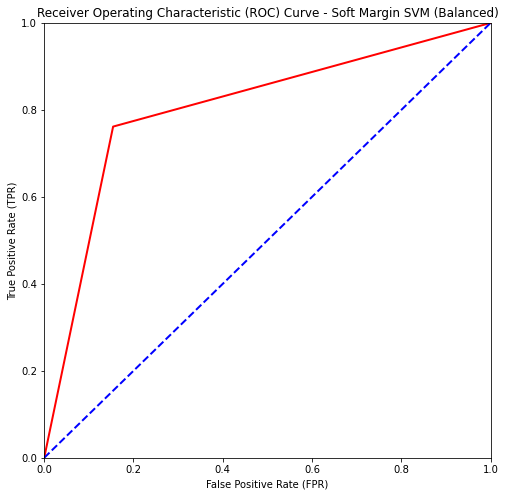

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, predicted_b_SVM)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Soft Margin SVM (Balanced)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

**Similar to the above two models, the permance of model is significanly affected the class imbalance and the model perform better when this issue is addressed.**